## Preambule

In [1]:
import numpy as np
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
path_main = Path("K:/Code/EffortSharing/")
path_data = Path("K:/Code/effort-sharing/data/output/")
#path_data = Path("K:/Data/Data_effortsharing/DataUpdate_25032025/")

## Read data

In [3]:
xr_dataread = xr.open_dataset(path_data / "startyear_2021/xr_dataread.nc")
all_regions_iso = np.load(path_data / "all_regions.npy")
all_regions_names = np.load(path_data / "all_regions_names.npy")
all_countries_iso = np.load(path_data / "all_countries.npy", allow_pickle=True)
all_countries_names = np.load(path_data / "all_countries_names.npy", allow_pickle=True)
xr_combs = xr.open_dataset(path_data / "startyear_2021/xr_comb.nc")

## Checks

Missing data

In [4]:
which = all_countries_iso[np.where(np.isnan(xr_dataread.HDIsh.sel(Region=all_countries_iso)))[0]]
val = len(which)
tot = len(all_countries_iso)

pop = float(np.nansum(xr_dataread.Population.sel(Region=which, Time=2021, Scenario='SSP2')))
globalpop = float(xr_dataread.Population.sel(Region='EARTH', Time=2021, Scenario='SSP2'))

print(val/tot, val)
print(pop/globalpop)
print(which)

0.03553299492385787 7
0.0024667237772590827
['COK' 'VAT' 'MCO' 'NRU' 'NIU' 'SOM' 'GMB']


Monotony

In [5]:
def is_increasing(lst):
    for i in range(1, len(lst)):
        if lst[i] < lst[i - 1]:
            return False
    return True

In [6]:
ctys_hdi = []
ctys_gdp = []
for cty in all_countries_iso:
    cats = xr_combs.Approach1_hdi.sel(Discount_factor=0, Category =["C1", "C3", "C6", "C8"], Historical_startyear=1990, Scenario='SSP2', Time=2030, Region=cty)
    if not is_increasing(cats.values[~np.isnan(cats.values)]):
        ctys_hdi.append(cty)

    cats = xr_combs.Approach1_gdp.sel(Discount_factor=0, Category =["C1", "C3", "C6", "C8"], Historical_startyear=1990, Scenario='SSP2', Time=2030, Region=cty)
    if not is_increasing(cats.values[~np.isnan(cats.values)]):
        ctys_gdp.append(cty)

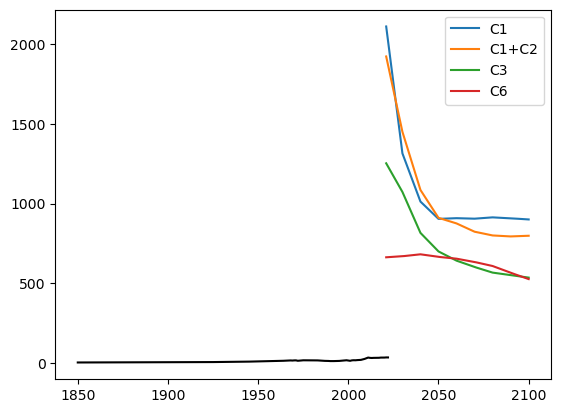

In [31]:
reg = 'AFG'
plt.plot(xr_dataread.Time, xr_dataread.GHG_hist_excl.sel(Region=reg), c='black')
for i in range(4):
    plt.plot(xr_combs.Time, xr_combs.sel(Convergence_year=2040, Discount_factor=0, Category =["C1", "C1+C2", "C3", "C6", "C8"][i], Historical_startyear=1990, Scenario='SSP2', Region=reg).Approach1_hdi, label=["C1", "C1+C2","C3", "C6", "C8"][i])
plt.legend()

## Ambition gap

In [33]:
ndcs = xr_dataread.GHG_ndc_excl_CR.sel(Conditionality = 'unconditional', Hot_air="include").mean(dim='Ambition')
allocs = xr_combs.Approach2.sel(Category='C1+C2', Scenario='SSP2', Time=2030, Discount_factor=0, Historical_startyear=1990)

In [34]:
gaps = (ndcs - allocs).sel(Region=all_countries_iso)
gaps2 = np.array(gaps)
gaps2[gaps2 < 0] = 0
totalgap = np.nansum(gaps2)

In [35]:
gaps.sel(Region=['CAN', 'FRA', 'DEU', 'GBR', 'ITA', 'JPN', 'USA', 'CHN', 'RUS']).sum() / totalgap

<xarray.DataArray ()> Size: 8B
array(0.65373581)
Coordinates:
    Conditionality        <U13 52B 'unconditional'
    Hot_air               <U7 28B 'include'
    Category              <U5 20B 'C1+C2'
    Scenario              <U4 16B 'SSP2'
    Discount_factor       float64 8B 0.0
    Historical_startyear  int32 4B 1990
    Time                  int32 4B 2030
    NonCO2red             float64 8B ...
    NegEmis               float64 8B ...
    Timing                <U9 36B ...

## Share data

In [45]:
df = xr_combs.sel(Scenario='SSP2', Discount_factor=0, Historical_startyear=1990, Convergence_year=2040, Time=np.arange(2021, 2101))[['GF', 'PC', 'Approach1_gdp', 'Approach2', 'Approach2t']].drop_vars(['NonCO2red', 'NegEmis', 'Timing', 'Convergence_year', 'Historical_startyear', 'Scenario', 'Discount_factor']).to_dataframe()

In [46]:
df.to_csv("K:/Code/effort-sharing/data/output/export_discontinuity.csv")